In [1]:
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import redis
import numpy as np
import redisConfig

from GA_audee import GA, ga_main
from SourceLocalisation import SourceLocaliser

# start redis server and config the maximum memory available
redisConfig.run()

os.environ['CUDA_VISIBLE_DEVICES'] = ''

Using TensorFlow backend.


Configured


In [2]:
model = keras.models.load_model('../external_model/alexnet-cifar10_origin.h5')
new_output = keras.layers.Softmax()(keras.layers.Dense(10, name="dense_3")(model.layers[-2].output)) # without specifying activation 
new_model = keras.models.Model(input=model.input, output=new_output)
new_model.layers[-2].set_weights(model.layers[-1].get_weights())
model = new_model

# model = keras.applications.ResNet50()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

# model = keras.applications.MobileNetV2()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

# model = keras.applications.VGG16()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

/data/yylaiai/anaconda3/envs/audee_test/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/data/yylaiai/anaconda3/envs/audee_test/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("so...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# load inputs
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# expand cifar10 images from 32x32 to 224x224
x_test_224 = np.array([cv2.resize(i, (224, 224)) for i in x_test])
print(x_test_224.shape)

(10000, 224, 224, 3)


In [4]:
mut_level = 'i+w'
model = model
x = x_test[0]/255
input_scale = 255 # image scale
init_noise = 0 # scale of Cauchy noise added in initialization
r1 = 0.5 # crossover rate
r2 = 0.3 # mutation rate
r3 = 0.01 # mutation scale (larger scale can trigger NaN inconsistency easier, smaller scale can increase layer distance easier)
m = 3 # top m chromosomes selected
n = 6 # population size
layer_idx = -2 # index of layer used in calculation of fitness values
db_flag = 3
maxIter = 1

r = redis.Redis(db=db_flag)
r.flushdb()

fit = ['inc', ['tensorflow', 'theano']]

In [7]:
ga = ga_main(fit, mut_level, model, x, input_scale, init_noise, r1, r2, r3, m, n, layer_idx, db_flag, maxIter)

Running at iteration 1:
Average fitness value: 170.12336425781248
Time taken: 201.9683916568756


Total time taken: 230.19718098640442


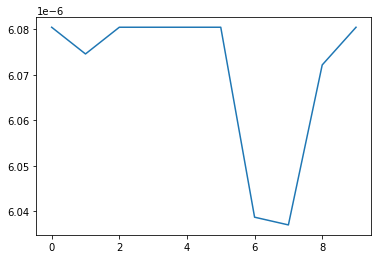

In [6]:
plt.plot(np.max(np.nan_to_num(ga.fit_hist, -1), axis=1))

In [8]:
def formatP(ga, idx):
    formatted_c = ga.formatPopulations(ga.P)[idx]
    if ga.mut_level == 'i':
        x = formatted_c
    elif ga.mut_level == 'w':
        x = ga.input
        ga.model.set_weights(formatted_c)
    elif ga.mut_level == 'i+w':
        x = formatted_c[0]
        ga.model.set_weights(formatted_c[1])

    return x, ga.model

x, m = formatP(ga, 0)

In [5]:
model_config = [
    {}, 
    {},
    {'padding': ['same']},
    {'center': [False]},
    {},
    {'padding': ['same']},
    {},
    {},
    {},
    {},
    {'padding': ['same']},
    
    {},
    {'padding': ['same']},
    {},
    {},
    {},
    {},
    {},
    {},
    {},
    {},
    
    {},
    {},
    {}
]

In [12]:
import importlib
import SourceLocalisation

importlib.reload(SourceLocalisation)
from SourceLocalisation import SourceLocaliser

In [13]:
SL = SourceLocaliser(model, ['tensorflow', 'theano'], x_test[0], model_config, 1)
SL.prepare()

In [14]:
SL.main(0.3, 0.1)

Localizing layer 2: MaxPooling2D...
Parameter "padding" is set to be "same"
Maximizing inconsistency of the input...

Time taken: 140.71633944590576


Localizing layer 3: BatchNormalization...
Parameter "center" is set to be "False"
Maximizing inconsistency of the input...
Inconsistency is localized in: 	center = True

Time taken: 147.94185844995081




/data/yylaiai/fyp21-22/GA/stable/audee_GA/SourceLocalisation.py:193: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("so...)`
  


Localizing layer 5: MaxPooling2D...
Parameter "padding" is set to be "same"
Maximizing inconsistency of the input...
Inconsistency is localized in: 	padding = valid

Time taken: 144.90271880407818


Localizing layer 5: MaxPooling2D...

Time taken: 19.91798299481161




([[3, ['center']], [5, ['padding']]], [])